In [1]:
import graphviz, sklearn
import numpy as np
import pandas as pd
import matplotlib.lines as mlines
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial

In [2]:
# fxn for plotting
def get_ax(figsize=(6,4)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

In [3]:
# D is the name of the data file
# returns a df with columns x_1, x_2, y of float values
def read_data(D):
    df = pd.read_csv("data/"+D, sep = " ", names = ["x_1", "x_2", "y"])
    return df

In [4]:
# D is a df
# returns a list of (feature, canidate split) tuples
def determine_candidate_splits(D):
    # init list of canidate splits
    C = []
    # loop through both features
    for feature in ["x_1", "x_2"]:
        # data_points is the feature and y columns of D into a df, sorted by X_i with idx 0, 1, 2, ...
        data_points = D[[feature, "y"]].sort_values(by=feature).reset_index(drop=True)
        
        # loop through data_df, read next value, label and next label
        for j in range(len(D)-1):
            val = data_points[feature][j+1]
            lab_1 = data_points["y"][j]
            lab_2 = data_points["y"][j+1]
            
            # check if adjacent labels mis-match, if True: append feature and val to C
            if lab_1 != lab_2:
                C.append((feature, val))
    return C

In [5]:
# Column is the lab column of D
# returns entropy of D[lab]
def H(Column):
    # get unique values and corresponding counts
    u_vals, u_counts = np.unique(Column, return_counts=True, axis=0)
    # counts to probabilities
    probs = u_counts/len(Column)
    # entropy fxn
    return np.sum((-1)*probs*np.log2(probs))

# D is a sorted df, idx is the index of the split
# returns (entropy of the split, conditional entropy)
def H_split(D, idx):   
    # get Y lists after split
    Y_1 = D["y"][:idx]
    Y_2 = D["y"][idx:]

    # ratio of the size of Y_i's vs whole set
    ratio_1 = len(Y_1) / len(D["y"])
    ratio_2 = len(Y_2) / len(D["y"])

    # entropy of Y given the split
    c_ent = (H(Y_1) * ratio_1) + (H(Y_2) * ratio_2)

    # entropy of the split
    H_s = 0
    # avoid log(0)
    if ratio_1 != 0:
        H_s += -(ratio_1 * np.log2(ratio_1))
    if ratio_2 != 0:
        H_s += -(ratio_2 * np.log2(ratio_2))
    return H_s, c_ent


# D is the data df, feature is "x_i", candidate is the splitter
# returns the gain ratio of the candidate split
def gain_ratio(D, feature, candidate):
    # entropy of untouched Y
    H_Y = H(D["y"])
    
    # get index of split
    D = D.sort_values(by=feature).reset_index(drop=True)
    idx = D[D[feature] == candidate].index.astype(int)[0]

    # get split entropy and conditional entropy
    H_s, c_ent = H_split(D, idx)
    # avoid 0 division
    if H_s != 0:    
        val = (H_Y - c_ent) / H_s
    else:
        val = None
    return val

# D is the data df, C is the candidate split list [(feature, split value), ...]
# returns (list of partitions, best feature, best splitter)
def find_best_split(D, C):
    # find best split
    # init best stuff
    best_feature = None
    best_splitter = None
    best_GR = 0
    
    # loop through C, find each gain ratio
    for feature, candidate in C:
        trial_GR = gain_ratio(D, feature, candidate)
        # avoid none type
        if trial_GR == None:
            continue
        # see if it is better than previous best
        if trial_GR > best_GR:
            best_feature = feature
            best_splitter = candidate
            best_GR = trial_GR
      
    # make split
    # sort data and re-index
    D = D.sort_values(by=best_feature).reset_index(drop=True)
    
    # find index of the splitter
    idx = D[D[best_feature] == best_splitter].index.astype(int)[0]
    
    # split data into two partitions
    smaller = D[:idx]
    bigger = D[idx:]
    
    return ([bigger, smaller], [best_feature, best_splitter])

In [6]:
# node is a df, splits are candidate splits (feature, value)
# returns a list of gains for each potential split in the node
def make_gain_list(node, splits):
    gains = []
    # loop over splits and find gain ratios
    for feature, candidate in splits:
        gains.append(gain_ratio(node, feature, candidate))
    return gains

# lst is a list(like)
# returns True if all values in lst are 0, False otherwise
def is_all_zero(lst):
    for value in lst:
        if value != 0:
            return False
    return True

# node is a df, splits are candidate splits (feature, value)
# returns True if all can. split entropies are 0, False otherwise
def any_zero_ents(node, splits):
    # loop through canidate splits
    for feature, splitter in splits:
        # get index of the splitter
        D = node.sort_values(by=feature).reset_index(drop=True)
        idx = D[D[feature] == splitter].index.astype(int)[0]
        
        # check if each split has 0 entropy
        if H_split(node, idx) == 0:
            # if yes => return True
            result = True
            break
        else:
            # otherwise return False
            result = False
    return result

# node is a df
# returns True if node satisfies a stopping condition, False otherwise
def is_stopper(node):
    # list of candidate splits
    can_splits = determine_candidate_splits(node)
    # list of gains of possible splits
    gain_list = make_gain_list(node, can_splits)
    # node is empty => stop
    if len(node) == 0:
        result = True
    # all splits have no gain => stop
    elif is_all_zero(gain_list):
        result = True
    # any candidate has 0 entropy => stop
    elif any_zero_ents(node, can_splits):
        result = True
    # otherwise => don't stop
    else:
        result = False
    return result

In [7]:
#g.node(name, printed label)
# D is a df, parent is the parent node
def make_leaf_node(D, parent, graph, leaf_number, edge_name):
    # u_vals is [0,1] or [1,0]
    # u_counts is a list of the corresponding counts
    # u_vals, u_counts = np.unique(D["y"], return_counts=True, axis=0)
    
    # find majority
    if np.sum(D["y"]) >= len(D)/2:
        label = "1"
    else:
        label = "0"
    # make node, add to tree and increment leaf number
    graph.node(parent + label, label)
    graph.edge(parent, parent + label, label=edge_name)
    return label

In [8]:
def make_internal_node(parent, label, graph, edge_name, s_col, s_val):
    # check if node is the root
    if parent == None:
        graph.node(label)
    else:
        graph.node(label)
        graph.edge(parent, label, label=edge_name)

In [9]:
# TODO: get rules to make prediction
# D is a data frame,
def make_subtree(D, parent, g, leaf_number, edge_name):
    sub_lst = []
    # check if we are at a leaf
    if is_stopper(D):
        label = make_leaf_node(D, parent, g, leaf_number, edge_name)
        sub_lst.append(label)
    else:
        # find best split and splitting feature
        C = determine_candidate_splits(D)
        S, splitting_feature = find_best_split(D, C)
        
        # get splitting column and value
        s_col = splitting_feature[0]
        s_val = splitting_feature[1]

        # make node       
        node_name = str(s_col) + " >= " + str(s_val)
        make_internal_node(parent, node_name, g, edge_name, s_col, s_val)
        
        sub_lst.append(node_name)
        
        # loop through splits and repeat
        # make_subtree isn't getting enough positional arguments
        for k in S:
            # get edge_name
            if min(k[s_col]) == s_val:
                edge_name = "True"
            else:
                edge_name = "False"
            sub_lst.append(make_subtree(k, node_name, g, leaf_number, edge_name))
            
    return sub_lst
# D is a df, creates and outputs the d tree
def make_tree(D, fname):
    g = graphviz.Digraph()
    leaf_number = 0
    rules = make_subtree(D, None, g, leaf_number, None)
    g.render(fname)
    return g, rules

In [10]:
# x1, x2 are trial points and tree is a list of lists
# [node, [true], [false]]

def predict_point(x_1, x_2, tree):
    points = {"x_1": x_1, "x_2":x_2}
    # check if at leaf
    if len(tree) == 1:
        return tree[0]
    # eval otherwise
    else:
        node = tree[0]
        label = node[:3]
        val = node[7:]
        if points[label] >= float(val):
            return predict_point(x_1, x_2, tree[1])
        else:
            return predict_point(x_1, x_2, tree[2])

In [11]:
D1_df = read_data("D1.txt")
D1_g, D1_rules = make_tree(D1_df, "trees/D1_tree")

In [12]:
D2_df = read_data("D2.txt")
D2_g, D2_rules = make_tree(D2_df, "trees/D2_tree")

In [13]:
Druns_df = read_data("Druns.txt")
make_tree(Druns_df, "trees/Druns_tree")

(<graphviz.graphs.Digraph at 0x13d2b670>,
 ['x_2 >= 8',
  ['1'],
  ['x_2 >= 0',
   ['x_2 >= 6', ['x_2 >= 7', ['0'], ['1']], ['0']],
   ['x_1 >= 0.1', ['0'], ['1']]]])

In [14]:
# 2.3
# get data
druns_splits = determine_candidate_splits(Druns_df)
druns_gains = make_gain_list(Druns_df, druns_splits)

In [ ]:
if gain == 0: print(mutual infor i.e. info gain)

In [15]:
# find candidate splits and gain ratio
for i in range(len(druns_splits)):
    print("feature:", druns_splits[i][0], "\n", "splitter:", druns_splits[i][1], "\n", "gain ratio:", druns_gains[i], "\n")

feature: x_1 
 splitter: 0.0 
 gain ratio: None 

feature: x_1 
 splitter: 0.0 
 gain ratio: None 

feature: x_1 
 splitter: 0.0 
 gain ratio: None 

feature: x_1 
 splitter: 0.0 
 gain ratio: None 

feature: x_1 
 splitter: 0.1 
 gain ratio: 0.10051807676021828 

feature: x_2 
 splitter: -1 
 gain ratio: 0.10051807676021828 

feature: x_2 
 splitter: 0 
 gain ratio: 0.055953759631263526 

feature: x_2 
 splitter: 6 
 gain ratio: 0.23609960614360798 

feature: x_2 
 splitter: 7 
 gain ratio: 0.055953759631263526 

feature: x_2 
 splitter: 8 
 gain ratio: 0.4301569161309807 



In [16]:
D3_df = read_data("D3leaves.txt")
make_tree(D3_df, "trees/D3_tree")

(<graphviz.graphs.Digraph at 0x13d3e6e8>,
 ['x_2 >= 2', ['1'], ['x_1 >= 10', ['1'], ['0']]])

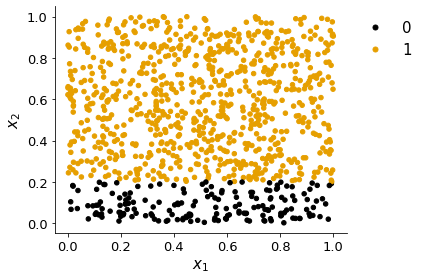

In [17]:
# make axies
ax = get_ax()

# set colors (colorblind friendly via https://yoshke.org/blog/colorblind-friendly-diagrams)
colors = {0: '#000000', 1: '#E69F00'}

# make plot
D1_df.plot.scatter(x="x_1", y="x_2", c=D1_df["y"].map(colors), ax=ax)

# plot settings
fsize = 15
# legend
b_dot = mlines.Line2D([], [], color='#000000', marker='.', linestyle='None',
                          markersize=10, label='0')
o_dot = mlines.Line2D([], [], color='#E69F00', marker='.', linestyle='None',
                          markersize=10, label='1')
ax.legend(handles=[b_dot, o_dot], fontsize=fsize, bbox_to_anchor=(1, 1), frameon=False)

# axies
plt.xticks(size=fsize-2)
plt.yticks(size=fsize-2)
plt.xlabel("$x_1$", size=fsize)
plt.ylabel("$x_2$", size=fsize)

plt.tight_layout()
plt.savefig("plots/D1_plot.pdf")

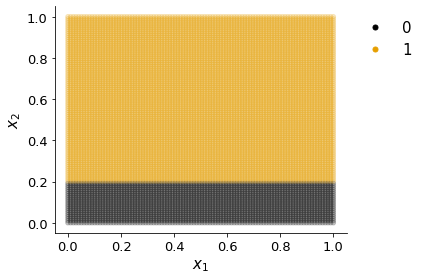

In [18]:
d1 = {"x_1":[], "x_2":[], "y":[]}
grid_x = np.linspace(0, 1, 100)
for x_1 in grid_x:
    for x_2 in grid_x:
        y = predict_point(x_1, x_2, D1_rules)
        d1["x_1"].append(x_1)
        d1["x_2"].append(x_2)
        d1["y"].append(int(y))

boundary1_df = pd.DataFrame(d1)

# make axies
ax = get_ax()

# set colors (colorblind friendly via https://yoshke.org/blog/colorblind-friendly-diagrams)
colors = {0: '#000000', 1: '#E69F00'}

# make plot
boundary1_df.plot.scatter(x="x_1", y="x_2", c=boundary1_df["y"].map(colors), alpha = 0.2, ax=ax)

# plot settings
fsize = 15
# legend
b_dot = mlines.Line2D([], [], color='#000000', marker='.', linestyle='None',
                          markersize=10, label='0')
o_dot = mlines.Line2D([], [], color='#E69F00', marker='.', linestyle='None',
                          markersize=10, label='1')
ax.legend(handles=[b_dot, o_dot], fontsize=fsize, bbox_to_anchor=(1, 1), frameon=False)

# axies
plt.xticks(size=fsize-2)
plt.yticks(size=fsize-2)
plt.xlabel("$x_1$", size=fsize)
plt.ylabel("$x_2$", size=fsize)

plt.tight_layout()
plt.savefig("plots/D1Boundary_plot.pdf")

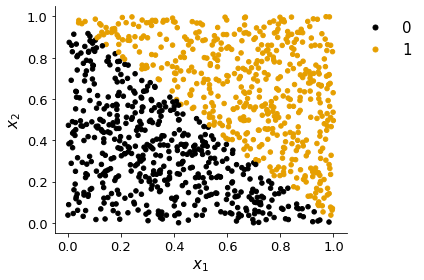

In [19]:
# make axies
ax = get_ax()


# set colors (colorblind friendly via https://yoshke.org/blog/colorblind-friendly-diagrams)
colors = {0: '#000000', 1: '#E69F00'}

# make plot
D2_df.plot.scatter(x="x_1", y="x_2", c=D2_df["y"].map(colors), ax=ax)

# plot settings
fsize = 15
# legend
b_dot = mlines.Line2D([], [], color='#000000', marker='.', linestyle='None',
                          markersize=10, label='0')
o_dot = mlines.Line2D([], [], color='#E69F00', marker='.', linestyle='None',
                          markersize=10, label='1')
ax.legend(handles=[b_dot, o_dot], fontsize=fsize, bbox_to_anchor=(1, 1), frameon=False)

# axies
plt.xticks(size=fsize-2)
plt.yticks(size=fsize-2)
plt.xlabel("$x_1$", size=fsize)
plt.ylabel("$x_2$", size=fsize)

plt.tight_layout()
plt.savefig("plots/D2_plot.pdf")

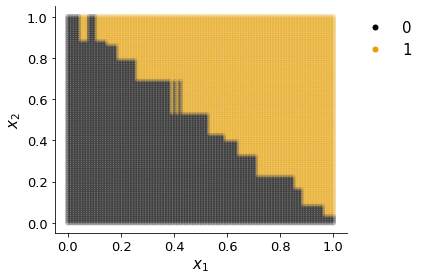

In [20]:
d2 = {"x_1":[], "x_2":[], "y":[]}
grid_x = np.linspace(0, 1, 100)
for x_1 in grid_x:
    for x_2 in grid_x:
        y = predict_point(x_1, x_2, D2_rules)
        d2["x_1"].append(x_1)
        d2["x_2"].append(x_2)
        d2["y"].append(int(y))

boundary2_df = pd.DataFrame(d2)

# make axies
ax = get_ax()

# set colors (colorblind friendly via https://yoshke.org/blog/colorblind-friendly-diagrams)
colors = {0: '#000000', 1: '#E69F00'}

# make plot
boundary2_df.plot.scatter(x="x_1", y="x_2", c=boundary2_df["y"].map(colors), alpha = 0.2, ax=ax)

# plot settings
fsize = 15
# legend
b_dot = mlines.Line2D([], [], color='#000000', marker='.', linestyle='None',
                          markersize=10, label='0')
o_dot = mlines.Line2D([], [], color='#E69F00', marker='.', linestyle='None',
                          markersize=10, label='1')
ax.legend(handles=[b_dot, o_dot], fontsize=fsize, bbox_to_anchor=(1, 1), frameon=False)

# axies
plt.xticks(size=fsize-2)
plt.yticks(size=fsize-2)
plt.xlabel("$x_1$", size=fsize)
plt.ylabel("$x_2$", size=fsize)

plt.tight_layout()
plt.savefig("plots/D2Boundary_plot.pdf")

In [21]:
Dbig_df = read_data("DBig.txt")

In [34]:
# scramble and split Dbig_df
scrambled_idxs = np.random.permutation(len(Dbig_df))

train_idxs = scrambled_idxs[:8192]

test_idxs = scrambled_idxs[8192:]
test_df = Dbig_df.iloc[test_idxs]

In [35]:
# get training subsets
D8192_df = Dbig_df.iloc[train_idxs]
D2048_df = D8192_df[:2048]
D512_df = D8192_df[:512]
D128_df = D8192_df[:128]
D32_df = D8192_df[:32]

In [38]:
D32_rules = make_tree(D32_df, "trees/D32_tree")[1]

In [39]:
D128_rules = make_tree(D128_df, "trees/D128_tree")[1]

In [40]:
D512_rules = make_tree(D512_df, "trees/D512_tree")[1]

In [41]:
D2048_rules = make_tree(D2048_df, "trees/D2048_tree")[1]

In [43]:
#D8192_rules = make_tree(D8192_df, "trees/D8192_tree")[1]

In [60]:
x_min = min(min(Dbig_df["x_1"]), min(Dbig_df["x_2"]))
x_max = max(max(Dbig_df["x_1"]), max(Dbig_df["x_2"]))

In [61]:
# limits
d8192 = {"x_1":[], "x_2":[], "y":[]}
d2048 = {"x_1":[], "x_2":[], "y":[]}
d512 = {"x_1":[], "x_2":[], "y":[]}
d128 = {"x_1":[], "x_2":[], "y":[]}
d32 = {"x_1":[], "x_2":[], "y":[]}
grid_x = np.linspace(x_min, x_max, 100)
for x_1 in grid_x:
    for x_2 in grid_x:
        y8192 = predict_point(x_1, x_2, D8192_rules)
        y2048 = predict_point(x_1, x_2, D2048_rules)
        y512 = predict_point(x_1, x_2, D512_rules)
        y128 = predict_point(x_1, x_2, D128_rules)
        y32 = predict_point(x_1, x_2, D32_rules)
        
        d8192["y"].append(int(y8192))
        d2048["y"].append(int(y2048))
        d512["y"].append(int(y512))
        d128["y"].append(int(y128))
        d32["y"].append(int(y32))
        
        d8192["x_1"].append(x_1)
        d2048["x_1"].append(x_1)
        d512["x_1"].append(x_1)
        d128["x_1"].append(x_1)
        d32["x_1"].append(x_1)
        
        d8192["x_2"].append(x_2)
        d2048["x_2"].append(x_2)
        d512["x_2"].append(x_2)
        d128["x_2"].append(x_2)
        d32["x_2"].append(x_2)
        
boundary32_df = pd.DataFrame(d32)        
boundary128_df = pd.DataFrame(d128)
boundary512_df = pd.DataFrame(d512)
boundary2048_df = pd.DataFrame(d2048)
boundary8192_df = pd.DataFrame(d8192)

In [62]:
predict_point(1., 0.4, D32_rules)

'0'

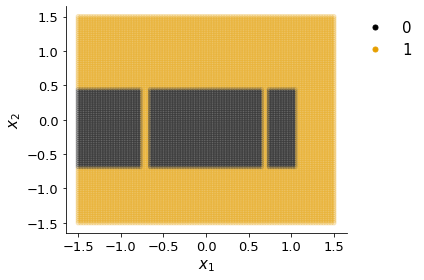

In [63]:
df = boundary32_df

# make axies
ax = get_ax()

# set colors (colorblind friendly via https://yoshke.org/blog/colorblind-friendly-diagrams)
colors = {0: '#000000', 1: '#E69F00'}

# make plot
df.plot.scatter(x="x_1", y="x_2", c=df["y"].map(colors), alpha = 0.2, ax=ax)

# plot settings
fsize = 15
# legend
b_dot = mlines.Line2D([], [], color='#000000', marker='.', linestyle='None',
                          markersize=10, label='0')
o_dot = mlines.Line2D([], [], color='#E69F00', marker='.', linestyle='None',
                          markersize=10, label='1')
ax.legend(handles=[b_dot, o_dot], fontsize=fsize, bbox_to_anchor=(1, 1), frameon=False)

# axies
plt.xticks(size=fsize-2)
plt.yticks(size=fsize-2)
plt.xlabel("$x_1$", size=fsize)
plt.ylabel("$x_2$", size=fsize)

plt.tight_layout()
plt.savefig("plots/D32Boundary_plot.pdf")

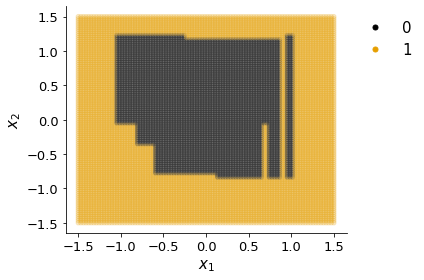

In [64]:
df = boundary128_df

# make axies
ax = get_ax()

# set colors (colorblind friendly via https://yoshke.org/blog/colorblind-friendly-diagrams)
colors = {0: '#000000', 1: '#E69F00'}

# make plot
df.plot.scatter(x="x_1", y="x_2", c=df["y"].map(colors), alpha = 0.2, ax=ax)

# plot settings
fsize = 15
# legend
b_dot = mlines.Line2D([], [], color='#000000', marker='.', linestyle='None',
                          markersize=10, label='0')
o_dot = mlines.Line2D([], [], color='#E69F00', marker='.', linestyle='None',
                          markersize=10, label='1')
ax.legend(handles=[b_dot, o_dot], fontsize=fsize, bbox_to_anchor=(1, 1), frameon=False)

# axies
plt.xticks(size=fsize-2)
plt.yticks(size=fsize-2)
plt.xlabel("$x_1$", size=fsize)
plt.ylabel("$x_2$", size=fsize)

plt.tight_layout()
plt.savefig("plots/D128Boundary_plot.pdf")

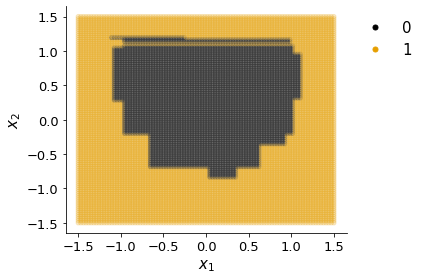

In [65]:
df = boundary512_df

# make axies
ax = get_ax()

# set colors (colorblind friendly via https://yoshke.org/blog/colorblind-friendly-diagrams)
colors = {0: '#000000', 1: '#E69F00'}

# make plot
df.plot.scatter(x="x_1", y="x_2", c=df["y"].map(colors), alpha = 0.2, ax=ax)

# plot settings
fsize = 15
# legend
b_dot = mlines.Line2D([], [], color='#000000', marker='.', linestyle='None',
                          markersize=10, label='0')
o_dot = mlines.Line2D([], [], color='#E69F00', marker='.', linestyle='None',
                          markersize=10, label='1')
ax.legend(handles=[b_dot, o_dot], fontsize=fsize, bbox_to_anchor=(1, 1), frameon=False)

# axies
plt.xticks(size=fsize-2)
plt.yticks(size=fsize-2)
plt.xlabel("$x_1$", size=fsize)
plt.ylabel("$x_2$", size=fsize)

plt.tight_layout()
plt.savefig("plots/D512Boundary_plot.pdf")

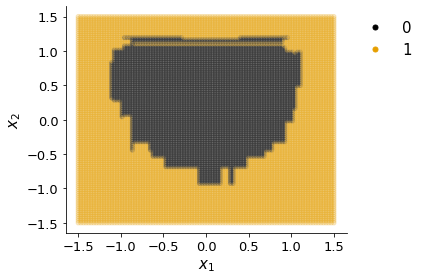

In [66]:
df = boundary2048_df

# make axies
ax = get_ax()

# set colors (colorblind friendly via https://yoshke.org/blog/colorblind-friendly-diagrams)
colors = {0: '#000000', 1: '#E69F00'}

# make plot
df.plot.scatter(x="x_1", y="x_2", c=df["y"].map(colors), alpha = 0.2, ax=ax)

# plot settings
fsize = 15
# legend
b_dot = mlines.Line2D([], [], color='#000000', marker='.', linestyle='None',
                          markersize=10, label='0')
o_dot = mlines.Line2D([], [], color='#E69F00', marker='.', linestyle='None',
                          markersize=10, label='1')
ax.legend(handles=[b_dot, o_dot], fontsize=fsize, bbox_to_anchor=(1, 1), frameon=False)

# axies
plt.xticks(size=fsize-2)
plt.yticks(size=fsize-2)
plt.xlabel("$x_1$", size=fsize)
plt.ylabel("$x_2$", size=fsize)

plt.tight_layout()
plt.savefig("plots/D2048Boundary_plot.pdf")

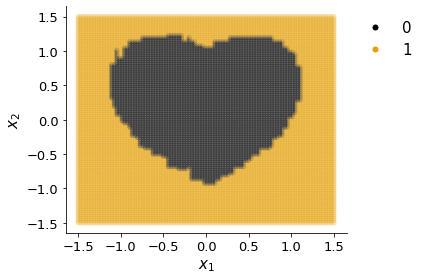

In [67]:
df = boundary8192_df

# make axies
ax = get_ax()

# set colors (colorblind friendly via https://yoshke.org/blog/colorblind-friendly-diagrams)
colors = {0: '#000000', 1: '#E69F00'}

# make plot
df.plot.scatter(x="x_1", y="x_2", c=df["y"].map(colors), alpha = 0.2, ax=ax)

# plot settings
fsize = 15
# legend
b_dot = mlines.Line2D([], [], color='#000000', marker='.', linestyle='None',
                          markersize=10, label='0')
o_dot = mlines.Line2D([], [], color='#E69F00', marker='.', linestyle='None',
                          markersize=10, label='1')
ax.legend(handles=[b_dot, o_dot], fontsize=fsize, bbox_to_anchor=(1, 1), frameon=False)

# axies
plt.xticks(size=fsize-2)
plt.yticks(size=fsize-2)
plt.xlabel("$x_1$", size=fsize)
plt.ylabel("$x_2$", size=fsize)

plt.tight_layout()
plt.savefig("plots/D8196Boundary_plot.pdf")

In [24]:
def Q3(D):
    sk_tree = DecisionTreeClassifier()
    sk_tree.fit(D[["x_1", "x_2"]], D["y"])
    
    num_nodes = sk_tree.tree_.node_count
    predictions = sk_tree.predict(test_df[["x_1", "x_2"]])

    error = sum(np.abs(predictions - test_df["y"]))
    
    return num_nodes, error

In [25]:
Q3(D2048_df)

(107, 35)

In [26]:
Q3(D512_df)

(51, 129)

In [27]:
Q3(D128_df)

(19, 155)

In [28]:
Q3(D32_df)

(7, 314)

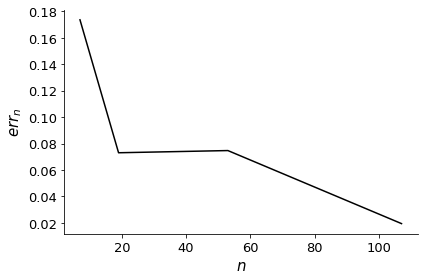

In [29]:
dfs = [D2048_df, D512_df, D128_df, D32_df]
n = []
err = []
for df in dfs:
    vals = Q3(df)
    n.append(vals[0])
    err.append(vals[1]/len(test_df))

ax = get_ax()

ax.plot(n, err, c="0")

# axies
plt.xticks(size=fsize-2)
plt.yticks(size=fsize-2)
plt.xlabel("$n$", size=fsize)
plt.ylabel("$err_n$", size=fsize)

plt.tight_layout()
plt.savefig("plots/sk_err_plot.pdf")

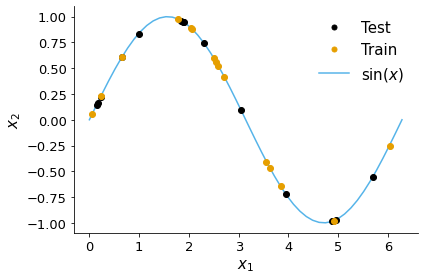

In [30]:
train_x = np.random.uniform(0, 2*np.pi, 15)
train_y = np.sin(train_x)

f = lagrange(train_x, train_y)

test_x = np.random.uniform(0, 2*np.pi, 15)

# make axies
ax = get_ax()

# set colors (colorblind friendly via https://yoshke.org/blog/colorblind-friendly-diagrams)
colors = {"Test": '#000000', "Train": '#E69F00', "$\sin(x)$": '#56B4E9'}

# make plot
plt.plot(np.linspace(0, 2*np.pi), np.sin(np.linspace(0, 2*np.pi)), c="#56B4E9", zorder=1)
plt.scatter(test_x, f(test_x), c="#000000", label="test", zorder=2)
plt.scatter(train_x, f(train_x), c="#E69F00", label="train", zorder=3)

# plot settings
fsize = 15
# legend
b_dot = mlines.Line2D([], [], color='#000000', marker='.', linestyle='None',
                          markersize=10, label='Test')
o_dot = mlines.Line2D([], [], color='#E69F00', marker='.', linestyle='None',
                          markersize=10, label='Train')
bu_dot = mlines.Line2D([], [], color='#56B4E9', linestyle='-',
                          markersize=10, label='$\sin(x)$')
ax.legend(handles=[b_dot, o_dot, bu_dot], fontsize=fsize, bbox_to_anchor=(1, 1), frameon=False)

# axies
plt.xticks(size=fsize-2)
plt.yticks(size=fsize-2)
plt.xlabel("$x_1$", size=fsize)
plt.ylabel("$x_2$", size=fsize)

plt.tight_layout()
plt.savefig("plots/lag_plot.pdf")

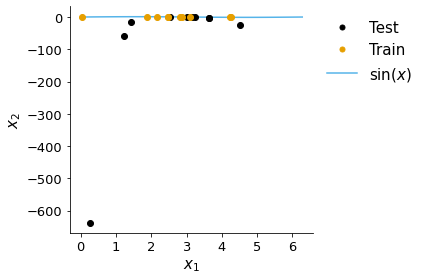

In [31]:
epsilon = 0.001
noise = np.random.normal(0, epsilon, 10)

train_x = np.random.uniform(0, 2*np.pi, 10)
train_y = np.sin(train_x)+noise

f = lagrange(train_x, train_y)

test_x = np.random.uniform(0, 2*np.pi, 10)

# make axies
ax = get_ax()

# set colors (colorblind friendly via https://yoshke.org/blog/colorblind-friendly-diagrams)
colors = {"Test": '#000000', "Train": '#E69F00', "$\sin(x)$": '#56B4E9'}

# make plot
plt.plot(np.linspace(0, 2*np.pi), np.sin(np.linspace(0, 2*np.pi)), c="#56B4E9", zorder=1)
plt.scatter(test_x, f(test_x), c="#000000", label="test", zorder=2)
plt.scatter(train_x, f(train_x), c="#E69F00", label="train", zorder=3)

# plot settings
fsize = 15
# legend
b_dot = mlines.Line2D([], [], color='#000000', marker='.', linestyle='None',
                          markersize=10, label='Test')
o_dot = mlines.Line2D([], [], color='#E69F00', marker='.', linestyle='None',
                          markersize=10, label='Train')
bu_dot = mlines.Line2D([], [], color='#56B4E9', linestyle='-',
                          markersize=10, label='$\sin(x)$')
ax.legend(handles=[b_dot, o_dot, bu_dot], fontsize=fsize, bbox_to_anchor=(1, 1), frameon=False)

# axies
plt.xticks(size=fsize-2)
plt.yticks(size=fsize-2)
plt.xlabel("$x_1$", size=fsize)
plt.ylabel("$x_2$", size=fsize)

plt.tight_layout()
plt.savefig("plots/lag_1ep_plot.pdf")

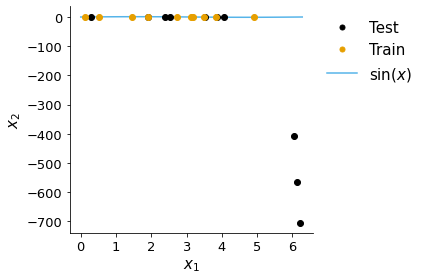

In [32]:
epsilon = 0.01
noise = np.random.normal(0, epsilon, 10)

train_x = np.random.uniform(0, 2*np.pi, 10)
train_y = np.sin(train_x)+noise

f = lagrange(train_x, train_y)

test_x = np.random.uniform(0, 2*np.pi, 10)

# make axies
ax = get_ax()

# set colors (colorblind friendly via https://yoshke.org/blog/colorblind-friendly-diagrams)
colors = {"Test": '#000000', "Train": '#E69F00', "$\sin(x)$": '#56B4E9'}

# make plot
plt.plot(np.linspace(0, 2*np.pi), np.sin(np.linspace(0, 2*np.pi)), c="#56B4E9", zorder=1)
plt.scatter(test_x, f(test_x), c="#000000", label="test", zorder=2)
plt.scatter(train_x, f(train_x), c="#E69F00", label="train", zorder=3)

# plot settings
fsize = 15
# legend
b_dot = mlines.Line2D([], [], color='#000000', marker='.', linestyle='None',
                          markersize=10, label='Test')
o_dot = mlines.Line2D([], [], color='#E69F00', marker='.', linestyle='None',
                          markersize=10, label='Train')
bu_dot = mlines.Line2D([], [], color='#56B4E9', linestyle='-',
                          markersize=10, label='$\sin(x)$')
ax.legend(handles=[b_dot, o_dot, bu_dot], fontsize=fsize, bbox_to_anchor=(1, 1), frameon=False)

# axies
plt.xticks(size=fsize-2)
plt.yticks(size=fsize-2)
plt.xlabel("$x_1$", size=fsize)
plt.ylabel("$x_2$", size=fsize)

plt.tight_layout()
plt.savefig("plots/lag_10ep_plot.pdf")

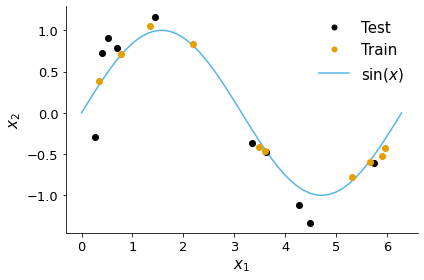

In [33]:
epsilon = 0.1
noise = np.random.normal(0, epsilon, 10)

train_x = np.random.uniform(0, 2*np.pi, 10)
train_y = np.sin(train_x)+noise

f = lagrange(train_x, train_y)

test_x = np.random.uniform(0, 2*np.pi, 10)

# make axies
ax = get_ax()

# set colors (colorblind friendly via https://yoshke.org/blog/colorblind-friendly-diagrams)
colors = {"Test": '#000000', "Train": '#E69F00', "$\sin(x)$": '#56B4E9'}

# make plot
plt.plot(np.linspace(0, 2*np.pi), np.sin(np.linspace(0, 2*np.pi)), c="#56B4E9", zorder=1)
plt.scatter(test_x, f(test_x), c="#000000", label="test", zorder=2)
plt.scatter(train_x, f(train_x), c="#E69F00", label="train", zorder=3)

# plot settings
fsize = 15
# legend
b_dot = mlines.Line2D([], [], color='#000000', marker='.', linestyle='None',
                          markersize=10, label='Test')
o_dot = mlines.Line2D([], [], color='#E69F00', marker='.', linestyle='None',
                          markersize=10, label='Train')
bu_dot = mlines.Line2D([], [], color='#56B4E9', linestyle='-',
                          markersize=10, label='$\sin(x)$')
ax.legend(handles=[b_dot, o_dot, bu_dot], fontsize=fsize, bbox_to_anchor=(1, 1), frameon=False)

# axies
plt.xticks(size=fsize-2)
plt.yticks(size=fsize-2)
plt.xlabel("$x_1$", size=fsize)
plt.ylabel("$x_2$", size=fsize)

plt.tight_layout()
plt.savefig("plots/lag_100ep_plot.pdf")